In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.linear_model import LinearRegression

from IPython.display import clear_output

import re

from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity

In [2]:
# one-hot encodes a list of suggestions

def transform_sugg(sugg, encoder):
    return encoder.transform(np.array(sugg).reshape(-1,1))

In [3]:
rws = pd.read_csv('./movies_data/requests_with_suggestions.csv')

#split suggestion string into list - this must be done here because csv files do not store lists
rws['sugg_split'] = rws['suggestions'].str.split('%')

#count the number of suggestions
rws['sugg_count'] = rws['sugg_split'].apply(len)

#split scores string into list, then convert each digit into an integer with the applied lambda function
rws['scores'] = rws['scores'].str.split(',').apply(lambda s : [int(i) for i in s])

In [4]:
all_titles = []

for sugg_list in rws['sugg_split']:
    for sugg in sugg_list:
        if sugg not in all_titles:
            all_titles.append(sugg)
            
len(all_titles)

8887

In [5]:
ohe = OneHotEncoder()

all_titles_ohe = ohe.fit_transform(np.array(all_titles).reshape(-1,1))

rws['sugg_ohe'] = rws['sugg_split'].apply(transform_sugg, encoder = ohe)

rws = rws.fillna('')

In [6]:
train_df, test_df = train_test_split(rws, test_size = 0.2, random_state = 1701)

In [7]:
#Create a dataframe that will store documents, each document being the text for which a title was suggested

movie_col = []
text_col = []
index_col = []

titles_col = train_df['title'].astype(str)
selftext_col = train_df['selftext'].astype(str)

for i in train_df.index.values:
    sugg_list = train_df['suggestions'][i].split('%')
    text = titles_col[i] + ' ' + selftext_col[i]
    
    for sugg in sugg_list:
        movie_col.append(sugg)
        text_col.append(text)
        index_col.append(i)

sugg_text_df = pd.DataFrame([movie_col, text_col, index_col]).T
sugg_text_df = sugg_text_df.rename(columns = {0:'title_id', 1:'text', 2: 'request_id'})
sugg_text_df = sugg_text_df.set_index('title_id')


In [8]:
# Create a dictionary that stores values of movie titles with keys of imdb title ids

movies = pd.read_csv('./movies_data/movies.csv')#.sort_values(by = 'year')

movies = movies[['id', 'primary_title', 'year']]

movies = movies[movies['id'].isin(sugg_text_df.index)] #https://stackoverflow.com/a/12098586

movies['year'] = movies['year'].astype(int)

movies = movies.sort_values(by = 'year')

title_dict = movies[['id', 'primary_title']].set_index('id').to_dict()['primary_title']

# Feature Optimization
----

The plan to evaluate the reccomendations is to compare test data to actual suggestions by the metric Recall
Recall only evaluates True Positives (movies suggested by both machine and humans) and False Negatives (movies suggested by humans but not by the machine)
This is ideal, becuase False Positives are not a big deal (and could, in fact, yield interesting results), and True Negatives make up the vast majority of the data.

Recall = TP / (TP + FN)

In a comparison of 20 recommendations, if the system predicts 5 of those titles, Recall = 5 / (5+ 15) = 0.25

To find a baseline for evaluation, the set of most recommended movies will be compared to the recommendations across all request documents. A "request document" is defined as the title + text of the recommendation, associated with a multilabel classification matrix of movie titles. This may be restricted to documents with reasonable number of suggestions (tenatively, 10 - 30), becuase as some requests saw nearly 1000 unique suggestions, the overlap between machine and human recommendations would become very large regardless of performance. Another approach would be to use comment scores to limit the suggestions to the top 20. The number 20 is chosen because that is approximately the average number of recommendations a request recieves.

To optimize features, recall will be measured, not with machine suggestions, but between the suggestions for each document and that document's most similar document in the corpus.


In [9]:
def vectorize_text(df, vectorizer, fit = True):
    #df should have 'id', 'title', and 'selftext' columns
    #function returns a dataframe with vectorized features, and the sparse matrix of features
    #the passed vectorizer is fit and can now transform other text, assuming it was initizialized outside of the function call
    
    doc_text_df = pd.DataFrame(zip(df['id'], df['title'] + df['selftext']), index = df['id'], columns = {0, 'documents'}).drop(columns = 0)

    if fit:
        X_features = vectorizer.fit_transform(doc_text_df['documents'])
    else:
        X_features = vectorizer.transform(doc_text_df['documents'])

    doc_vectors_df = pd.DataFrame(X_features.toarray(), columns = vectorizer.get_feature_names(), index = doc_text_df.index)
    
    return doc_vectors_df, X_features

In [10]:
# returns a dictionary that maps each document to their most similar document(s) and their similarity score(s)
#   as a list of tuples like: (title_id, cosine_distance)

def get_similarity_dict(dist_df, size = 1):
    sim_dict = {tt_id : [] for tt_id in dist_df}
    
    for item in dist_df:
        try:
            most_similar = dist_df[item].sort_values()[1 : 1 + size]
        except:
            print(f"Problem with: {item}")
        for i in range(len(most_similar)):
            sim_dict[item].append((most_similar.index.values[i], most_similar.values[i]))
        
    return sim_dict

In [11]:
#Get a recall score for two sets of laebels + scores

def compare_labels(labels1, scores1, labels2, scores2, encoder, limits = [10, 20]):
    
    if len(labels1) == 0 or len(labels2) == 0:
        return 0.0
    
    labels1_df = pd.DataFrame(zip(labels1, scores1), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)
    labels2_df = pd.DataFrame(zip(labels2, scores2), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)
    
    #assign small and large on the assumption that 1 is large and 2 is small, check this assumption only if they aren't equal size
    large = labels1_df
    small = labels2_df
    
    # check if we need to select a limited portion of the passed labels before processing
    if len(labels1) != len(labels2) or len(labels1) not in range(limits[0], limits[1]+1):
        
        if len(labels1) < len(labels2):
            large = labels2_df
            small = labels1_df

        try:
            cutoff = large['score'][min(len(small), limits[1])]
        except:
            print(len(small))
        
        pared_large = large[large['score'] > cutoff]
        
        size = min(len(small), limits[1])
        
        difference = size - len(pared_large)
        
        while difference > 0:
            to_sample = difference
            
            if difference > len(large[large['score'] == cutoff]):
                to_sample = len(large[large['score'] == cutoff])
                
            pared_large = pared_large.append(large[large['score'] == cutoff].sample(to_sample))
            
            difference = size - len(pared_large)
            
            cutoff -= 1
            
            if cutoff < -1:
                break
        
        if(len(small)) > limits[1]:

            cutoff = small['score'][limits[1]-1]
            pared_small = small[small['score'] > cutoff]
            difference = limits[1] - len(pared_small)
        
            while difference > 0:
                to_sample = difference
            
                if difference > len(small[small['score'] == cutoff]):
                    to_sample = len(small[small['score'] == cutoff])

                pared_small = pared_small.append(small[small['score'] == cutoff].sample(to_sample))

                difference = limits[1] - len(pared_small)
                
                cutoff -= 1
                
                if cutoff < -1:
                    break
            
            small = pared_small
                
        large = pared_large
    
    # this is recall: cosine_similarity sum = True Positives, len(small) = all positives
    
    return cosine_similarity(transform_sugg(large['label'], encoder=encoder),
                        transform_sugg(small['label'], encoder=encoder)).sum() / len(small)

In [12]:
def get_recall_and_distance(df, similarity_dict, encoder, limits = [10,20], verbose = True, num_matches = 1):
# This function needs a dataframe and a similarity dictionary made with that dataframe
    count = 0

    np.random.seed(1701)

    recall_scores = []
    cos_distances = []

    for tt_id in df['id']:

        for i in range(num_matches):
            best_match = similarity_dict[tt_id][i][0]

            labels1 = df[df['id'] == tt_id]['sugg_split'].values[0]
            scores1 = df[df['id'] == tt_id]['scores'].values[0]

            labels2 = df[df['id'] == best_match]['sugg_split'].values[0]
            scores2 = df[df['id'] == best_match]['scores'].values[0]

            recall_scores.append(compare_labels(labels1, scores1, labels2, scores2, encoder = encoder, limits = limits))
            cos_distances.append(similarity_dict[tt_id][i][1])

        clear_output(wait = True)

        count += 1
        if count % 100 == 0:
            if verbose:
                print(f'{count} / {df.shape[0]}')
    
    if verbose:
        print(np.mean(recall_scores))
    
    return recall_scores, cos_distances

In [13]:
class Features_Evaluator:
    
    def __init__(self, df, vec, enc):
        self.df = df
        self.vectorizer = vec
        self.encoder = enc
        self.lr_fit = False
        
    def fit_vectorizer(self):
        doc_text_df = pd.DataFrame(zip(self.df['id'], self.df['title'] + self.df['selftext']),
                                   index = self.df['id'], columns = {0, 'documents'}).drop(columns = 0)
        self.vectorizer.fit(doc_text_df['documents'])
        
    def transform_with_vectorizer(self, test_df):
        df = test_df
        
        doc_text_df = pd.DataFrame(zip(df['id'], df['title'] + df['selftext']),
                                   index = df['id'], columns = {0, 'documents'}).drop(columns = 0)
        
        X_features = self.vectorizer.transform(doc_text_df['documents'])
        
        return X_features
        
    
    def vectorize_text(self, fit = False):
        
        df = self.df
        vec = self.vectorizer
        
        doc_text_df = pd.DataFrame(zip(df['id'], df['title'] + df['selftext']), index = df['id'], columns = {0, 'documents'}).drop(columns = 0)

        if fit:
            X_features = vec.fit_transform(doc_text_df['documents'])
        else:
            try: 
                X_features = vec.transform(doc_text_df['documents'])
            except:
                print("Vectorizer is not fit. Use fit = True or call fit_vectorizer().")
                return

        doc_vectors_df = pd.DataFrame(X_features.toarray(), columns = vec.get_feature_names(), index = doc_text_df.index)
        
        cd_matrix = cosine_distances(X_features)

        doc_distance_df = pd.DataFrame(index = doc_vectors_df.index, columns = doc_vectors_df.index, data = cd_matrix)
        
        self.doc_vectors_df = doc_vectors_df
        self.doc_distance_df = doc_distance_df
        self.X_features = X_features
        
    def transform_sugg(self, sugg):
        return self.encoder.transform(np.array(sugg).reshape(-1,1))
    
    def make_similarity_dict(self, size = 1):
        dist_df = self.doc_distance_df
        
        sim_dict = {tt_id : [] for tt_id in dist_df}
        
        for item in dist_df:
            try:
                most_similar = dist_df[item].sort_values()[1 : 1 + size]
            except:
                print(f"Problem with: {item}")
            for i in range(len(most_similar)):
                sim_dict[item].append((most_similar.index.values[i], most_similar.values[i]))
        
        self.similarity_dict = sim_dict
        
    def get_similarity_dict(self):
        return self.similarity_dict
    
    def compare_labels(self, labels1, scores1, labels2, scores2, limits = [10, 20]):
        
        if len(labels1) == 0 or len(labels2) == 0:
            return 0.0
        
        labels1_df = pd.DataFrame(zip(labels1, scores1), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)
        labels2_df = pd.DataFrame(zip(labels2, scores2), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)

        #assign small and large on the assumption that 1 is large and 2 is small, check this assumption only if they aren't equal size
        large = labels1_df
        small = labels2_df

        # check if we need to select a limited portion of the passed labels before processing
        if len(labels1) != len(labels2) or len(labels1) not in range(limits[0], limits[1]+1):

            if len(labels1) < len(labels2):
                large = labels2_df
                small = labels1_df

            try:
                cutoff = large['score'][min(len(small), limits[1])]
            except:
                print(len(small))

            pared_large = large[large['score'] > cutoff]

            size = min(len(small), limits[1])

            difference = size - len(pared_large)

            while difference > 0:
                to_sample = difference

                if difference > len(large[large['score'] == cutoff]):
                    to_sample = len(large[large['score'] == cutoff])

                pared_large = pared_large.append(large[large['score'] == cutoff].sample(to_sample))

                difference = size - len(pared_large)

                cutoff -= 1

                if cutoff < -1:
                    break

            if(len(small)) > limits[1]:

                cutoff = small['score'][limits[1]-1]
                pared_small = small[small['score'] > cutoff]
                difference = limits[1] - len(pared_small)

                while difference > 0:
                    to_sample = difference

                    if difference > len(small[small['score'] == cutoff]):
                        to_sample = len(small[small['score'] == cutoff])

                    pared_small = pared_small.append(small[small['score'] == cutoff].sample(to_sample))

                    difference = limits[1] - len(pared_small)

                    cutoff -= 1

                    if cutoff < -1:
                        break

                small = pared_small

            large = pared_large
        
        # this is recall: cosine_similarity sum = True Positives, len(small) = all positives
        
        return cosine_similarity(self.transform_sugg(large['label']),
                            self.transform_sugg(small['label'])).sum() / len(small)
    
    def get_recall_and_distance(self, limits = [10,20], verbose = True, num_matches = 1):
    # This function needs a dataframe and a similarity dictionary made with that dataframe
        count = 0
        
        df = self.df

        np.random.seed(1701)

        recall_scores = []
        cos_distances = []
        
        for tt_id in df['id']:

            for i in range(num_matches):
                best_match = self.similarity_dict[tt_id][i][0]

                labels1 = df[df['id'] == tt_id]['sugg_split'].values[0]
                scores1 = df[df['id'] == tt_id]['scores'].values[0]

                labels2 = df[df['id'] == best_match]['sugg_split'].values[0]
                scores2 = df[df['id'] == best_match]['scores'].values[0]

                recall_scores.append(self.compare_labels(labels1, scores1, labels2, scores2, limits = limits))
                cos_distances.append(self.similarity_dict[tt_id][i][1])

            

            count += 1
            if count % 100 == 0:
                if verbose:
                    clear_output(wait = True)
                    print(f'{count} / {df.shape[0]}')

        if verbose:
            print(f'Average recall: {np.mean(recall_scores)}')
        
        self.avg_recall = np.mean(recall_scores)
        self.avg_distance = np.mean(cos_distances)
        self.recall_scores = recall_scores
        self.cos_distances = cos_distances
        
    def linreg_recall(self):
        self.lr = LinearRegression()
        try:
            self.lr.fit(1 - np.array(self.cos_distances).reshape(-1,1), self.recall_scores)
        except:
            print("Recall and Distances not calculated.")
            return
        self.slope = self.lr.coef_
        self.intercept = self.lr.intercept_
        self.pred1 = self.lr.predict(np.array(1).reshape(-1,1))
        self.lr_fit = True
        
        
    def print_lrstats(self):
        if self.lr_fit == False:
            self.linreg_recall()
        print(f'Slope:   {np.round(self.slope,4)}\nIntercept: {np.round(self.intercept, 4)}\nAt 1.0:   {np.round(self.pred1,4)}')
        
    def plot_recall_and_distance(self):
        if self.lr_fit == False:
            self.linreg_recall()
            
        sns.set_context('talk')
        
        fig = plt.figure(constrained_layout = True, figsize = (10,10))
        gs = gridspec.GridSpec(nrows = 5, ncols = 5, figure = fig)
        ax0 = fig.add_subplot(gs[0:4, 0:4])
        ax0.set_ylabel("Recall")
        ax0.set_title("Recall Scores vs Cosine Similarity", fontsize = 20)
        ax0.set_xlabel("Request Similarity")
        ax1 = fig.add_subplot(gs[4, 0:4])
        #ax1.set_title("Cosine Similarity", fontsize = 16)
        ax2 = fig.add_subplot(gs[0:4, 4])
        #ax2.set_title("Recall Scores", fontsize = 16)
        
        ax0.set_ylim(-0.05, 1.05)
        ax0.set_xlim(-0.05, 1.05)
        ax1.set_xlim(ax0.get_xlim())
        ax2.set_ylim(ax0.get_ylim())
        ax0.set_xticklabels([])
        ax2.set_yticklabels([])
        ax1.set_xlabel(ax0.get_xlabel())
        ax0.set_xlabel('')
        ax0.set_xticks([])
        ax2.set_yticks([])

        x = np.linspace(0,1)
        ax0.plot(x, self.slope * x + self.intercept, color = 'gold', lw =3)
        ax0.scatter(1 - np.array(self.cos_distances), self.recall_scores, alpha  = 0.07, color = 'seagreen')

        sns.distplot(1 - np.array(self.cos_distances), ax = ax1, bins = 50, color = 'seagreen')
        sns.distplot(self.recall_scores, ax = ax2, vertical = True, bins = 30, color = 'seagreen');
        
    def process_df(self, dict_size = 1, num_matches = 1, label_limits = [10, 20], verbose = False):
        self.vectorize_text(fit = True)
        self.make_similarity_dict(size = dict_size)
        self.get_recall_and_distance(limits = label_limits, num_matches = num_matches, verbose = verbose)
        self.linreg_recall()

In [19]:
def get_prediction(query_string):
    query_vec = tf.transform([query_string])
    query_df = pd.DataFrame(query_vec.toarray(), columns = tf.get_feature_names()).T
    
    features = query_df.loc[query_df[0] > 0].index.values

    rec_dict = {title : 0 for title in titles_and_features.index.values}
    
    #Find every potential match:

    for feat in features:
        title_vectors = titles_and_features[feat].sort_values(ascending = False)
        for i in title_vectors.index:
            rec_dict[i] += title_vectors[i]

    score_df = pd.DataFrame(rec_dict, index = ['score']).T
    
    #The df with potential matches:
    score_df = score_df.loc[score_df['score'] > 0].sort_values(by = 'score', ascending = False)
    #the vectors corresponding to the matched titles:
    labels_df = titles_and_features.T[score_df.index].T
    
    if len(labels_df) > 0:
    
        id_and_scores = zip(labels_df.index, cosine_similarity(X = labels_df, Y = query_df.T))

        ranking_dict = {}

        for tt_id, score in id_and_scores:
            ranking_dict[tt_id] = score

        final_df = pd.DataFrame(ranking_dict).T.rename(columns = {0 : 'score'}).sort_values(by = 'score', ascending = False)[:10]
    else:
        return [], [], pd.DataFrame(columns = ['score'])
    
    return final_df.index.values, np.arange(10,0,-1), final_df

In [20]:
#Get the recall from row "n" of "test_df" using predictions from "predict_function"

def recall_row(predict_function, test_df, n):
    row = test_df[n:n+1]
    query = row['title'].values[0] + ' ' + row['selftext'].values[0]

    query_labels, label_scores, labels_df = predict_function(query)

    true = row['sugg_split'].values[0]
    true_scores = row['scores'].values[0]
    return compare_labels(true, true_scores, query_labels, label_scores, encoder = ohe, limits = [0,len(query_labels)])

In [21]:
def get_prediction_doc_vector(query_string):
    #Do a tfidf or countvectorize transformation to get a list of potential matches
    
    query_vec = tf.transform([query_string])
    query_df = pd.DataFrame(query_vec.toarray(), columns = tf.get_feature_names()).T

    features = query_df.loc[query_df[0] > 0].index.values

    rec_dict = {title : 0 for title in titles_and_features.index.values}

    #Find every potential match:

    for feat in features:
        title_vectors = titles_and_features[feat].sort_values(ascending = False)
        for i in title_vectors.index:
            rec_dict[i] += title_vectors[i]

    score_df = pd.DataFrame(rec_dict, index = ['score']).T

    #The df with potential matches:
    score_df = score_df.loc[score_df['score'] > 0].sort_values(by = 'score', ascending = False)
    #the vectors corresponding to the matched titles:
    labels_df = titles_and_vectors.T[score_df.index].T

    if len(labels_df) > 0:
        query_vector = nlp(query_string).vector
        id_and_scores = zip(labels_df.index, [scipy.spatial.distance.cosine(labels_df['vector'][i], query_vector) for i in range(labels_df.shape[0])])

        ranking_dict = {}

        for tt_id, score in id_and_scores:
            ranking_dict[tt_id] = score

        final_df = pd.DataFrame(data = [list(ranking_dict), list(ranking_dict.values())]).T.rename(columns = {1 : 'score'}).set_index(0).sort_values(by = 'score', ascending = False)[:10]
    else:
        return [], [], pd.DataFrame(columns = ['score'])
    
    return final_df.index.values, np.arange(10,0,-1), final_df

My ideal comparison size (for now) is in the range between 10 and 20. This provides a good number of suggestions without increasing the number so much that the comparison is meaningless. (For example, requests with 500 suggestions would have extremely high overlap, and likely have much in common with the list of 500 most suggested movies) Requests with > 20 suggestions will be pared down based on score.
This brings up a new problem: If a request has 30 suggestions, and 15 of them have score "1", and I am trying to compare to a 20-suggestion request, I will need to either:
- **A**) Limit the comparison to slices that *can* be compared accurately between 2 documents, or,
- **B**) Randomly sample the remaining suggestions to fill out the last 5 suggestions.

**A** is problematic because it will often not be possible to find any score cut-off that allows a direct comparison of top *x* suggestions between two requests. **B** is necessary because, although it is likely that suggestions are not ordered in any meaningful way, it is good to be certain that I am not optimizing for an unintentionally skewed distribution. The best solution could be to combine these: find the score cutoffs that allows the direct comparison which discards the least amount of information in my target range.

# BASELINE

In [ ]:
#The baseline is simply comparing the list of most popular movies to the suggestions in the test data

In [22]:
most_popular_titles = sugg_text_df.groupby('title_id').count().sort_values(by = 'text', ascending = False)[:10].index.values

In [23]:
rank = list(range(len(most_popular_titles), 0, -1))

In [58]:
for title in most_popular_titles:
    print(title_dict[title])

Up
Star Trek Into Darkness
Love
Them!
Life
Her
2012
Toy Story 3
After
In Time


In [25]:
rank

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [26]:
recall_sum = 0
found_matches = 0

for n in range(len(test_df)):
    recall = recall_row(lambda x: (most_popular_titles, rank, None), test_df, n)
    recall_sum += recall
    if recall > 0:
        found_matches += 1
        
    clear_output(wait = True)
    print(f'{round(100 * n/len(test_df), 2)}%')
        
print(recall_sum / len(test_df))
print(found_matches)

99.94%
0.033866239245986245
400


The baseline of reccommending the most popular movies every time is 3.46% with 406 of 1738 queries (23.4%) having some match
This is very, very wrong because of the common words (up, love, time, her, after) being incorrectly labeled as suggestions.

PLAN: Keep removing titles unitl a reasonable list of titles is found. Add those titles back in with better title matching such as matching "Up (2009)" instead of just "up" which is in many cases a false positive.

# spaCy

SpaCy can be used to create document vectors. Testing showed that this was not useful without training a model on the corpus. This could be useful, but I will need to train a model specifically on this dataset to get anything out of it. For now, corpus-specific doument vectors will be made by training an LDA model with gensim library.

In [395]:
import spacy

In [15]:
nlp = spacy.load('en_core_web_lg')

In [198]:
train_df['document'] = train_df['title'] + ' ' + train_df['selftext']

train_df['document'] = train_df['document'].apply(simplify_text)

training_corpus = [nlp(doc) for doc in train_df['document']]

train_df['vector'] = [training_corpus[n].vector for n in range(len(train_df))]

C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


NameError: name 'nlp' is not defined

In [27]:
movie_col = []
text_col = []
vector_col = []

titles_col = train_df['title'].astype(str)
selftext_col = train_df['selftext'].astype(str)

for i in train_df.index.values:
    sugg_list = train_df['suggestions'][i].split('%')
    text = titles_col[i] + ' ' + selftext_col[i]
    vector = train_df['vector'][i]
    
    for sugg in sugg_list:
        movie_col.append(sugg)
        text_col.append(text)
        vector_col.append(vector)

sugg_text_df = pd.DataFrame([movie_col, text_col, vector_col]).T
sugg_text_df = sugg_text_df.rename(columns = {0:'title_id', 1:'text', 2:'vector'})
sugg_text_df = sugg_text_df.set_index('title_id')

In [28]:
# Mean vector of documents with movie as a suggestion
titles = sugg_text_df.index.unique()
vectors = [] # [np.mean(sugg_text_df.loc[x]['vector'].values, axis = 0) for x in titles]

count = 0

for x in titles:
    count +=1
    try:
        #This will fail if there is only one suggestion for a title
        vectors.append(np.mean(sugg_text_df.loc[x]['vector'].values, axis = 0))
    except:
        vectors.append(sugg_text_df.loc[x]['vector'])

In [29]:
titles_and_vectors = pd.DataFrame([titles, vectors]).T

titles_and_vectors = titles_and_vectors.rename(columns = {0:'title_id', 1:'vector'}).set_index('title_id')

# Search through tfidf features on trainind data

In [14]:
tf = TfidfVectorizer(max_features=5000, ngram_range=(1,3), stop_words='english')

doc_vectors_df, X = vectorize_text(rws, tf)

In [28]:
train_df10 = train_df[train_df['sugg_count'] >= 10]
test_df10 = test_df[test_df['sugg_count'] >= 10]


In [19]:
tfidf_features = pd.DataFrame(columns = ['ngrams', 'max_features', 'max_df', 'min_df', 'avg_recall', 'avg_distance', 'intercept', 'pred1'])
tfidf_features = pd.read_csv('movies_data/tfidf_gridsearch_results.csv')
print(len(tfidf_features))

162


In [53]:
#Manual gridsearch over Tfidf features

ngrams = [(3,3), (3,4), (3,5)]
max_features = [5000,7500,1000]
max_df = [0.01, 1.0]
min_df = [1]

iterations = len(ngrams) * len(max_features) * len(max_df) * len(min_df)
count = 0

for ng in ngrams:
    for mx_f in max_features:
        for mx_d in max_df:
            for mn_d in min_df:
                count +=1
                print(f'{count} / {iterations}')
                
                tf = TfidfVectorizer(ngram_range = ng, max_df = mx_d, min_df = mn_d, max_features=mx_f, stop_words='english')
                fe = Features_Evaluator(train_df, tf, ohe)
                fe.process_df()
                
                tfidf_features = tfidf_features.append({'max_df' : mx_d, 'max_features' : mx_f, 'min_df' : mn_d, 'ngrams' : ng,
                                       'avg_recall' : fe.avg_recall,
                                       'avg_distance' : fe.avg_distance,
                                       'intercept' : fe.intercept,
                                       'pred1' : fe.pred1}, ignore_index = True)

tfidf_features

1 / 18
2 / 18
3 / 18
4 / 18
5 / 18
6 / 18
7 / 18
8 / 18
9 / 18
10 / 18
11 / 18
12 / 18
13 / 18
14 / 18
15 / 18
16 / 18
17 / 18
18 / 18


,ngrams,max_features,max_df,min_df,avg_recall,avg_distance,intercept,pred1
0,"(1, 1)",1000,0.10,1.000,0.048891,0.529460,0.127078,[-0.02059501]
1,"(1, 1)",1000,0.10,0.005,0.045758,0.510569,0.121347,[-0.02670107]
2,"(1, 1)",1000,0.10,0.010,0.044712,0.420111,0.124190,[-0.06499373]
3,"(1, 1)",1000,0.30,1.000,0.049713,0.545726,0.134669,[-0.02100554]
4,"(1, 1)",1000,0.30,0.005,0.045647,0.528849,0.121042,[-0.02152322]
...,...,...,...,...,...,...,...,...
157,"(3, 5)",5000,1.00,1.000,0.058938,0.589661,0.182143,[-0.02679943960312023]
158,"(3, 5)",7500,0.01,1.000,0.058201,0.597429,0.179029,[-0.023218059081327513]
159,"(3, 5)",7500,1.00,1.000,0.058266,0.595541,0.178405,[-0.02332635952131565]
160,"(3, 5)",1000,0.01,1.000,0.086424,0.574475,0.221482,[-0.01361632891218495]


In [54]:
tfidf_features.to_csv('./movies_data/tfidf_gridsearch_results.csv', index = False)

In [64]:
tfidf_features[144:].groupby(by = 'min_df').mean()

,max_df,avg_recall,avg_distance,intercept
min_df,,,,
1,0.534615,0.058725,0.677225,0.167461


In [23]:
tfidf_features[144:].groupby(by = 'max_df').mean()

,max_features,min_df,avg_recall,avg_distance,intercept
max_df,,,,,
0.01,15000,1.0,0.049159,0.675763,0.160410
0.05,15000,1.0,0.048638,0.673206,0.157707
0.70,15000,1.0,0.048954,0.671413,0.161324
1.00,15000,1.0,0.048954,0.671413,0.161324


In [24]:
tfidf_features[144:].groupby(by = 'ngrams').mean()

,max_features,max_df,min_df,avg_recall,avg_distance,intercept
ngrams,,,,,,
"(2, 2)",15000,0.44,1.0,0.047195,0.700193,0.151928
"(2, 3)",15000,0.44,1.0,0.046733,0.670561,0.147861
"(3, 3)",15000,0.44,1.0,0.052850,0.648093,0.180786


In [25]:
tfidf_features[144:].groupby(by = 'max_features').mean()

,max_df,min_df,avg_recall,avg_distance,intercept
max_features,,,,,
10000,0.44,1.0,0.050546,0.652603,0.163866
15000,0.44,1.0,0.049259,0.675127,0.160983
20000,0.44,1.0,0.046973,0.691117,0.155725


In [33]:
labels, scores, df = get_prediction("I want to watch an exciting action movie with a unique plot and amazing actors")

In [34]:
for label in labels:
    print(title_dict[label])

Kafka
No One Lives
True Lies
Mad Max: Fury Road
Raid
Shoot 'Em Up
Twin Dragons
Eddie
Uncle Boonmee Who Can Recall His Past Lives
Fury


# Visualize the dataset based on different features

 -----

In [29]:
tf = TfidfVectorizer(max_features= 15000, max_df = 1.0, ngram_range = (1,1), stop_words='english')
fe = Features_Evaluator(train_df10, tf, ohe)

In [30]:
fe.process_df(verbose = True)

3600 / 3657
Average recall: 0.059745666650079986


In [318]:
fe.avg_recall

0.059745666650079986

In [392]:
fe.print_lrstats()

Slope:   [0.1899]
Intercept: 0.002
At 1.0:   [0.1919]


C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


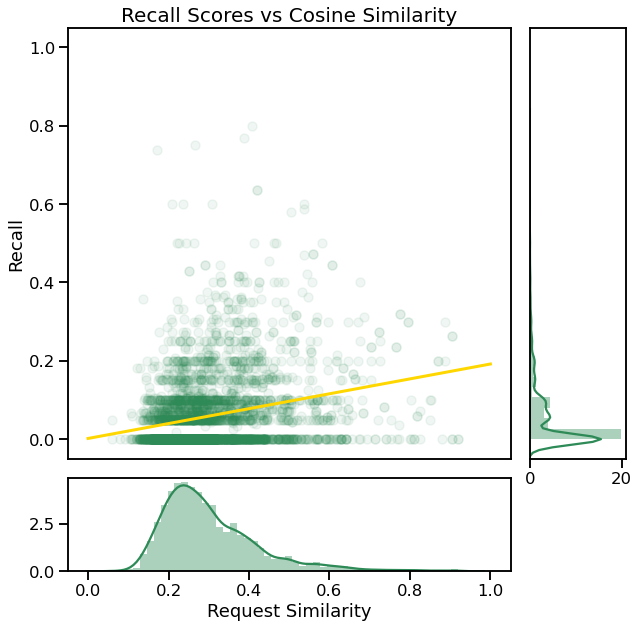

In [393]:
fe.plot_recall_and_distance()

---

In [462]:
titles_and_features

,00,000,00s,02,08,10,100,1000,10000,1000th,...,zoolander,zoology,zoomers,zooms,zorro,zucchini,zuckerberg,zulu,zzb9wo,östlund
title,,,,,,,,,,,,,,,,,,,,,
tt1734493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt4263482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0457430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt4846232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0443706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt2543472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt3799694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt2494280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
query_labels, label_scores, labels_df = get_prediction(train_df[12:13]['document'].values[0])

In [151]:
for item in labels_df.index:
    print(title_dict[item])

All That Jazz
The Florida Project
Under the Silver Lake
New York
Vivarium
Arrival
The Double
Sorry to Bother You
Predestination
Coherence


# Find the average recall across all predictions on testing data

In [31]:
X = fe.vectorizer.transform(sugg_text_df['text'])

titles_and_features = pd.DataFrame(X.toarray(), columns = fe.vectorizer.get_feature_names(), index = sugg_text_df.index)
    
titles_and_features = titles_and_features.groupby(by = 'title_id').mean()

titles_and_features

,00,000,00s,02,08,10,100,1000,10000,1000th,...,zoolander,zoology,zoomers,zooms,zorro,zucchini,zuckerberg,zulu,zzb9wo,östlund
title_id,,,,,,,,,,,,,,,,,,,,,
tt0006864,0.0,0.0,0.0,0.0,0.0,0.076757,0.046897,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0009968,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0010323,0.0,0.0,0.0,0.0,0.0,0.057751,0.005029,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0011237,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0012364,0.0,0.0,0.0,0.0,0.0,0.038337,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9777644,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt9779516,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt9806192,0.0,0.0,0.0,0.0,0.0,0.046216,0.005110,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
recall_sum = 0
found_matches = 0

tf = TfidfVectorizer(max_features = 3000, max_df=.1, stop_words='english')
fe = Features_Evaluator(train_df, tf, ohe)
fe.fit_vectorizer()
tf = fe.vectorizer

X = fe.vectorizer.transform(sugg_text_df['text'])

titles_and_features = pd.DataFrame(X.toarray(), columns = fe.vectorizer.get_feature_names(), index = sugg_text_df.index)
    
titles_and_features = titles_and_features.groupby(by = 'title_id').mean()

for n in range(len(test_df)):
    recall = recall_row(get_prediction_doc_vector, test_df, n)
    recall_sum += recall
    if recall > 0:
        found_matches += 1
        
    clear_output(wait = True)
    print(f'{round(100 * n/len(test_df), 2)}%')
        
print(recall_sum / len(test_df))
print(found_matches)

99.94%
0.0002109704641350211
3


In [ ]:
found_matches / len(test_df)

TFIDF Testing Recall:

Trial 1:

- ngramgs = 3,3
- features = 1000
- max_df = 0.01

- Training "recall" (est) = 0.0845
- Testing recall = **0.0301**
- 15% of queries had match

Trial 2:

- ngrams = 1,1
- features = 15,000
- max_df = 1.0

- Training "recall" = 0.0597
- Testing recall = **0.0353**
- 20.1% of queries had match

Trial 3:

- ngrams = 1,2
- features = 8,000
- max_df = 0.1

- Training "recall" = 0.0566
- Testing  = **0.0281**
- 16.6% of queries had match

Document vectors (spaCy) testing recall:

- Tfidf 1-grams and 15k features for initial matching

- Testing score: **0.0**

- Absolutely nothing had any match, for real. May need to train language model on this corpus and not use a pre-trained language model.

Trial 2:

- Tfidf 1-grams with 3k features, max_df = 0.1

- Testing score: *0.0002*

- 3 queries had a match

In [441]:
tfidf_features.sort_values(by = 'avg_recall', ascending = False)[:20]

,ngrams,max_features,max_df,min_df,avg_recall,avg_distance,intercept,pred1
160,"(3, 5)",1000,0.01,1.0,0.086424,0.574475,0.221482,[-0.01361633]
155,"(3, 4)",1000,1.00,1.0,0.084489,0.572490,0.215175,[-0.01310211]
148,"(3, 3)",1000,0.01,1.0,0.084486,0.576370,0.221874,[-0.01649355]
154,"(3, 4)",1000,0.01,1.0,0.084062,0.578304,0.218357,[-0.01386538]
161,"(3, 5)",1000,1.00,1.0,0.083737,0.571651,0.214059,[-0.0139147]
149,"(3, 3)",1000,1.00,1.0,0.082428,0.574006,0.215416,[-0.01626713]
89,"(1, 1)",15000,1.00,1.0,0.061908,0.696911,0.192790,[0.00498771]
83,"(1, 1)",5000,1.00,1.0,0.061288,0.653829,0.185852,[-0.00466304]
15,"(1, 1)",5000,1.00,1.0,0.061288,0.653829,0.185852,[-0.00466304]
85,"(1, 1)",10000,0.50,1.0,0.060915,0.688857,0.192963,[0.00127138]


In [500]:
train_df

,id,created_utc,title,selftext,suggestions,scores,sugg_split,sugg_count,sugg_ohe
3946,gikeq0,1589317548,Thriller Movies that take place in a House at ...,"The plot twist in Parasite, Identity ,",tt0340855%tt6378710,"[1, 1]","[tt0340855, tt6378710]",2,"(0, 4303)\t1.0\n (1, 8519)\t1.0"
6633,ej2eje,1577991384,What is your favorite “sexy” movie from the 90s?,,tt0109456%tt0110308%tt0120890%tt0169547%tt0139134,"[4, 2, 7, 7, 7]","[tt0109456, tt0110308, tt0120890, tt0169547, t...",5,"(0, 2586)\t1.0\n (1, 2628)\t1.0\n (2, 3282..."
4539,g3vdey,1587245087,Non-American comedy films with a different sen...,I'd like to see some non-American comedy films...,tt0092048%tt3011894%tt0080801%tt1465522%tt1512...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[tt0092048, tt3011894, tt0080801, tt1465522, t...",40,"(0, 1807)\t1.0\n (1, 7578)\t1.0\n (2, 1314..."
2218,hlemnq,1593913193,Movies where their memory is erased,"Like Bourne identity, memento or the long kiss...",tt0338013%tt0083658%tt0309698%tt1386703%tt0102...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[tt0338013, tt0083658, tt0309698, tt1386703, t...",15,"(0, 4278)\t1.0\n (1, 1417)\t1.0\n (2, 4125..."
282,ir7jj1,1599892112,Looking for movies where the main character is...,I recently watched Anna. I've watched Salt way...,tt5316540%tt1662557%tt3508840%tt7556122%tt0451...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[tt5316540, tt1662557, tt3508840, tt7556122, t...",72,"(0, 8291)\t1.0\n (1, 6584)\t1.0\n (2, 7763..."
...,...,...,...,...,...,...,...,...,...
3916,gjq9s4,1589475613,Looking for movies/shows specifically about sc...,I'll also accept shows and movies where this i...,tt1242460%tt0105327%tt2334896%tt6527426%tt1068...,"[1, 1, 2, 2, 1, 2, 2, 1, 1, 1]","[tt1242460, tt0105327, tt2334896, tt6527426, t...",10,"(0, 6014)\t1.0\n (1, 2408)\t1.0\n (2, 7238..."
5459,fkpkuq,1584538404,Movies that inadvertently predicted the future?,Do you know how The Simpsons unknowingly predi...,tt0097216,[1],[tt0097216],1,"(0, 2040)\t1.0"
5614,fgoib1,1583887667,Movies on Netflix,Looking for some hidden gem movies on Netflix....,tt1798709%tt2316411%tt4178092%tt1602613%tt4263...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[tt1798709, tt2316411, tt4178092, tt1602613, t...",18,"(0, 6760)\t1.0\n (1, 7216)\t1.0\n (2, 7980..."
5636,ffk8ap,1583705853,"Best ""inside a simulation"" movies?",I really like the Matrix and want something ki...,tt0109303%tt0120907,"[1, 1]","[tt0109303, tt0120907]",2,"(0, 2570)\t1.0\n (1, 3288)\t1.0"


# FFNN

In [396]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, MaxPool1D
import numpy.linalg.linalg as la

In [42]:
# Psuedo-Code:
# X_train = train_df text+titles vectorized (fit_transform)
# y_train = train_df sugg_ohe
# X_test = test_tf text+titles transformed
# y_test = test_df sugg_ohe

# But....should it be limited to top answers? top 20? 10? would have to re-do encoding for labels

In [17]:
tv = TfidfVectorizer(ngram_range=(1,1), max_features= 15_000, stop_words='english')
fe = Features_Evaluator(train_df, tv, ohe)

fe.vectorize_text(fit = True)

X_train = fe.X_features
X_test = fe.transform_with_vectorizer(test_df)

In [401]:
y_train = train_df['sugg_ohe']
y_test = test_df['sugg_ohe']

In [402]:
y_train_dense = [list((la.dot(np.ones((1, y_train[n].shape[0])), y_train[n].todense())).A[0]) for n in y_train.index]
y_test_dense = [list((la.dot(np.ones((1, y_test[n].shape[0])), y_test[n].todense())).A[0]) for n in y_test.index]

In [30]:
y_train_dense = np.asarray(y_train_dense)
y_test_dense = np.asarray(y_test_dense)

In [108]:
model = Sequential()


#model.add(Conv1D(input_shape = (None, 1, X_train.shape[0]), filters = 2, kernel_size = 6, activation = 'relu', padding = 'same'))
model.add(Dense(1000, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(y_train[0].shape[1], activation = 'softmax'))

model.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])

In [25]:
X_train_rs = np.asarray(X_train.todense())
X_test_rs =  np.asarray(X_test.todense())

In [120]:
history = model.fit(X_train_rs,
                    y_train_dense,
                    batch_size=512,
                    validation_data=(X_test_rs, y_test_dense),
                    epochs=30)

Epoch 1/30
14/14 [==============================] - 3s 234ms/step - loss: 0.0162 - acc: 0.0272 - val_loss: 0.0196 - val_acc: 0.0058
Epoch 2/30
14/14 [==============================] - 3s 225ms/step - loss: 0.0162 - acc: 0.0282 - val_loss: 0.0197 - val_acc: 0.0075
Epoch 3/30
14/14 [==============================] - 3s 215ms/step - loss: 0.0161 - acc: 0.0284 - val_loss: 0.0197 - val_acc: 0.0081
Epoch 4/30
14/14 [==============================] - 3s 223ms/step - loss: 0.0161 - acc: 0.0298 - val_loss: 0.0197 - val_acc: 0.0052
Epoch 5/30
14/14 [==============================] - 3s 223ms/step - loss: 0.0161 - acc: 0.0289 - val_loss: 0.0197 - val_acc: 0.0046
Epoch 6/30
14/14 [==============================] - 3s 218ms/step - loss: 0.0160 - acc: 0.0296 - val_loss: 0.0198 - val_acc: 0.0040
Epoch 7/30
14/14 [==============================] - 3s 239ms/step - loss: 0.0160 - acc: 0.0320 - val_loss: 0.0198 - val_acc: 0.0046
Epoch 8/30
14/14 [==============================] - 3s 233ms/step - loss: 0.

In [121]:
preds = model.predict(X_test_rs[111:112])

pred_df = pd.DataFrame(zip(preds[0], movies['id'])).sort_values(by = 0, ascending = False)[:10]

for tt in pred_df[1]:
    try:
        print(title_dict[tt])
    except:
        print(tt)

# LDA

In [35]:
from gensim import corpora
from gensim import models
from gensim.utils import simple_preprocess
from collections import defaultdict
from nltk.stem import PorterStemmer
from nltk.tokenize import NLTKWordTokenizer
from nltk.corpus import stopwords

In [36]:
def simplify_text(s):
    s = re.sub('[!,.:;\'\\u2019\\u0027]', '', re.sub('[^a-zA-Z0-9\'\\u2019]', ' ', re.sub('https://[=?\-_./\w]+', ' ', s)))
    return s

In [ ]:
#Modified from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#4whatdoesldado

In [37]:
documents_train = train_df['title'] + ' ' + train_df['selftext']
documents_test = test_df['title'] + ' ' + test_df['selftext']

In [38]:
ps = PorterStemmer()
tok = NLTKWordTokenizer()

In [39]:
tokenized_documents_train = []
tokenized_documents_test = []
count = 0
size = len(documents_train.index) + len(documents_test.index)

sw_ext = stopwords.words('english')
sw_ext.extend(['movie', 'movies', 'like', 'please', 'help', 'maybe',
               'film', 'watch', 'watched', 'see', 'seen', 'saw',
               'title', 'suggest', 'recommend', 'thank', 'thanks',
               'www', 'com', 'org', 'net', 'reddit', 'imdb',
               'good', 'look', 'looking', 'films', 'really',
               'one', 'something', 'similar', 'im', 'ive', #this marks the end of the stopwords used for the LDA gridsearch
               'also', 'want', 'suggestions', 'suggestion', 
               'recommendation', 'would', 'people', 'know',
               'dont', 'anything', 'etc', 'get', 'need'])

# stem and Tokenize documents, ignoring english stopwords

for n in documents_train.index:
    tokenized_documents_train.append([t for t in simple_preprocess(documents_train[n]) if t not in sw_ext])
    count +=1
    if count % 10 == 0:
        clear_output(wait = True)
        print(round(100* count/size,3))
        
for n in documents_test.index:
    tokenized_documents_test.append([t for t in simple_preprocess(documents_test[n]) if t not in sw_ext])
    count +=1
    if count % 10 == 0:
        clear_output(wait = True)
        print(round(100* count/size,3))

99.931


In [40]:
#initialized only with training data - this propogates to the corpora and id2word dictonaries
bigram = models.Phrases(tokenized_documents_train, threshold= 10)
trigram = models.Phrases(bigram[tokenized_documents_train], threshold= 10, min_count = 5)

In [41]:
trigram_tokens_train = trigram[tokenized_documents_train]
trigram_tokens_test = trigram[tokenized_documents_test]

In [42]:
id2word_train = corpora.Dictionary(trigram_tokens_train)
#id2word_test = corpora.Dictionary(trigram_tokens_test)

In [43]:
corpus_train = [id2word_train.doc2bow(text) for text in trigram_tokens_train]
corpus_test = [id2word_train.doc2bow(text) for text in trigram_tokens_test]

In [186]:
# find new stopwords by analyzing frequent words

frequecy_dict = {}

for sent in trigram_tokens_train:
    for word in sent:
        if word in frequecy_dict.keys():
            frequecy_dict[word] += 1
        else:
            frequecy_dict[word] = 1


In [187]:
frequecy_df= pd.DataFrame.from_dict(frequecy_dict, orient='index').sort_values(by = 0, ascending=False)

In [189]:
frequecy_df.head(20)

,0
love,972
horror,873
great,593
time,574
think,538
feel,529
best,486
action,449
genre,438
characters,437


In [192]:
coherence_scores = {}

for n in range(5,30):
    lda = models.ldamodel.LdaModel(corpus = corpus_train, id2word=id2word_train,
                                   random_state=1701, chunksize=1000,
                                   passes = 10, per_word_topics=True,
                                   num_topics = n)
     
    coherence_model_lda = models.CoherenceModel(model=lda, texts=trigram_tokens_train, dictionary=id2word_train, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    coherence_scores[n] = (coherence_lda, lda.log_perplexity(corpus_test))
    
    clear_output(wait=True)
    print(n)

c_scores_df = pd.DataFrame.from_dict(coherence_scores, orient='index', columns=['coherence', 'perplexity'])

29


ValueError: 1 columns passed, passed data had 2 columns

In [193]:
c_scores_df = pd.DataFrame.from_dict(coherence_scores, orient='index', columns=['coherence', 'perplexity'])

LDA Hyperparameter tuning:

chunk_size = 100, passes = 10, per_word_topics = True, n = range(5,30)
- 9  - 0.382645
- 24 - 0.371630

chunk_size = 200, passes = 3, per_word_topics = True, n = range(5,30)
- 6  - 0.400209
- 18 - 0.421928
- 21 - 0.404575

chunk_size = 500, passes = 3, per_word_topics = False, n = range(5,30)
- 5  - 0.421062
- 9  - 0.428878
- 18 - 0.422019
- 21 - 0.422390
- 27 - 0.367435 (among the lowest)

chunk_size = 500, passes = 10, per_word_topics = False, n = [5,9,18,21,27]
- 5 	0.419707
- 9 	0.436628
- 18 	0.430952
- 21 	0.427658
- 27 	0.384030

chunk_size = 1000, passes = 3, per_word_topics = False, n = range(5,30)
- 8 	0.450151
- 9 	0.384563
- 12 	0.423510
- 17 	0.428103
- 18 	0.410491
- 24 	0.425700

chunk_size = 1000, passes = 10, per_word_topics = False, n = [8,9,12,17,18,24]
- 8 	0.452270
- 9 	0.386336
- 12 	0.443579
- 17 	0.429789
- 18 	0.448779
- 24 	0.430006

chunk_size = 1000, passes = 10, per_word_topics = False, n = range(30,51)
- 30 	0.399737 (low)
- 35 	0.384121 (lowest)
- 39 	0.420466
- 47 	0.419874

chunk_size = 1000, passes = 20, per_word_topics = False, n = [8,12,18]
- 8 	0.443469
- 12 	0.442776
- 18 	0.459121

chunk_size = 1000, passes = 20, per_word_topics = True, n = [8,12,18]
- 8 	0.443469 ... 	-10.111030
- 12 	0.442776 ... 	-10.840400
- 18 	0.459121 ... 	-12.080242
- 47 	0.418886 ... 	-16.379946

chunk_size = 1000, passes = 20, per_word_topics = True, n = [8,12,18, 47], more stopwords
- 8 : 	0.384413 ...	 -10.265378
- 12: 	0.378753 ...	 -10.990508
- 18: 	0.436485 ...	 -12.258767
- 47: 	0.411224 ...	 -16.802233

chunk_size = 1000, passes = 10, pwt = True, n = range(5,30), more stopwords
- 15 	0.401872 	-11.803768
- 18 	 0.444403 ... -12.297003
- all others < 0.4

chunk_size = 2000, passes = 3, per_word_topics = False, n = range(5,30)
- 12 	0.416177
- 18 	0.416214
- 28 	0.401652

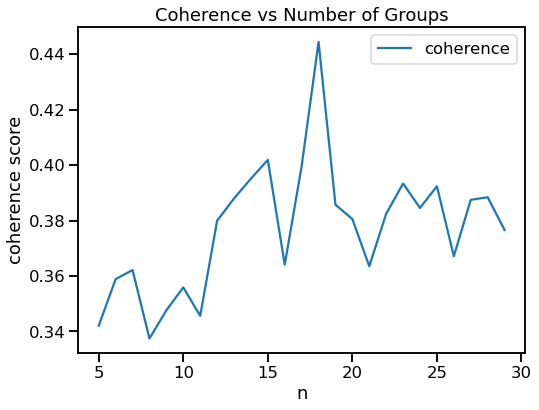

In [206]:
sns.set_context('talk')
c_scores_df.plot(y = 'coherence', figsize = (8,6))
plt.title("Coherence vs Number of Groups")
plt.xlabel("n")
plt.ylabel("coherence score");

In [44]:
lda = models.ldamodel.LdaModel(corpus = corpus_train, id2word=id2word_train,
                               random_state=1701, chunksize=1000,
                               passes = 20, per_word_topics=True,
                               num_topics = 18)

In [45]:
coherence_model_lda = models.CoherenceModel(model=lda, texts=trigram_tokens_train, dictionary=id2word_train, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

coherence_lda

0.43201200045379273

In [74]:
coherence_model_lda = models.CoherenceModel(model=lda, texts=trigram_tokens_test, dictionary=id2word_train, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

coherence_lda

In [ ]:
#Test data coherence > train data coherence. Why? Does coherence score favor smaller datasets?

In [46]:
#Create vectors that represent each request text using LDA
corp_train_vectors = np.zeros((len(corpus_train), lda.num_topics))
corp_test_vectors = np.zeros((len(corpus_test), lda.num_topics))
n=0
total_len = len(corpus_train) + len(corpus_test)

for c in corpus_train:
    
    for topic in lda.get_document_topics(c):
        corp_train_vectors[n][topic[0]] = topic[1]
        
    n+=1
    if n%10 == 0:
        clear_output(wait=True)
        print(round(100 * n/total_len, 3))
    
m=0
    
for c in corpus_test:
    
    for topic in lda.get_document_topics(c):
        corp_test_vectors[m][topic[0]] = topic[1]
        
    n+=1
    m+=1
    if n%10 == 0:
        clear_output(wait=True)
        print(round(100 * n/total_len, 3))

99.931


In [47]:
corp_test_vectors

array([[0.18010968, 0.15077691, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19099966, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01851967, 0.01851967, 0.01851967, ..., 0.01851967, 0.01851967,
        0.01851967],
       ...,
       [0.        , 0.        , 0.        , ..., 0.25849745, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07901225, 0.        , ..., 0.09978542, 0.        ,
        0.        ]])

In [48]:
#Create a dictionary that maps the training data index to its resepctive document in the tokenized corpus
vector_by_id = {train_df.index[n] : corp_train_vectors[n] for n in range(len(train_df))}

In [49]:
# Create a list that contains a vector for each movie suggestion

sugg_vectors = np.zeros((sugg_text_df.shape[0], lda.num_topics))

n = 0

while n < sugg_vectors.shape[0]:
    sugg_vectors[n] = vector_by_id[sugg_text_df['request_id'][n]]
    
    n += 1
    
    if n%500 == 0:
        clear_output(wait=True)
        print(round(100 * n/sugg_vectors.shape[0],3))

99.997


In [50]:
# Take the list of vectors and group them by title - make vectors for each

title_ids = sugg_text_df.index.unique()
title_vectors_avg = []
title_vectors_max = []
title_vectors_avg_f = []
title_vectors_max_f = []
title_id_vector_dict = {}

count = 0

for i in title_ids:
    max_vec = np.zeros(lda.num_topics)
    sum_vec = np.zeros(lda.num_topics)
    vec_total = 0
    
    vectors = sugg_vectors[sugg_text_df.index.get_loc(i)]
    
    #If there is only vector in the list, it will be 1-dimensional and we should not iterate through it
    if(len(vectors.shape)) == 1:
        max_vec = vectors
        sum_vec = vectors
        vec_total = 1
    else:
        for vec in sugg_vectors[sugg_text_df.index.get_loc(i)]:
            max_vec = np.maximum(vec, max_vec)
            sum_vec += vec
            vec_total += 1
            
    avg_vec = sum_vec / vec_total
    
    title_vectors_avg.append(avg_vec)
    title_vectors_max.append(max_vec)
    title_vectors_avg_f.append(avg_vec - min(avg_vec))
    title_vectors_max_f.append(max_vec - min(max_vec))
    
    count+=1
    clear_output(wait=True)
    print(round(100 * count/title_ids.shape[0],3))

100.0


In [51]:
#turn the array into a dataframe of features
title_vectors_df_avg = pd.DataFrame(data = title_vectors_avg, index = title_ids)
title_vectors_df_max = pd.DataFrame(data = title_vectors_max, index = title_ids)
title_vectors_df_avg_f = pd.DataFrame(data = title_vectors_avg_f, index = title_ids)
title_vectors_df_max_f = pd.DataFrame(data = title_vectors_max_f, index = title_ids)

In [52]:
### get recall/acc for testing data:
n = 0
recall_avg_sum = 0
recall_max_sum = 0
recall_avg_f_sum = 0
recall_max_f_sum = 0

for i in test_df.index:
    row = test_df.loc[i]
    topics = lda.get_document_topics(corpus_test[n])
    vector = np.zeros(lda.num_topics)

    for topic in topics:
            vector[topic[0]] = topic[1]

    scores_avg = cosine_similarity([vector],title_vectors_df_avg)
    scores_max = cosine_similarity([vector],title_vectors_df_max)
    scores_avg_f = cosine_similarity([vector],title_vectors_df_avg_f)
    scores_max_f = cosine_similarity([vector],title_vectors_df_max_f)
    
    
    titles = title_ids

    sim_df_avg = pd.DataFrame(zip(titles, scores_avg[0]), columns = ['title', 'score']).sort_values(by = 'score', ascending = False)[:10]
    sim_df_max = pd.DataFrame(zip(titles, scores_max[0]), columns = ['title', 'score']).sort_values(by = 'score', ascending = False)[:10]
    sim_df_avg_f = pd.DataFrame(zip(titles, scores_avg_f[0]), columns = ['title', 'score']).sort_values(by = 'score', ascending = False)[:10]
    sim_df_max_f = pd.DataFrame(zip(titles, scores_max_f[0]), columns = ['title', 'score']).sort_values(by = 'score', ascending = False)[:10]

    scores = list(range(10,0,-1))
    
    labels = sim_df_avg['title'].values
    
    recall_avg = compare_labels(row['sugg_split'], row['scores'], labels, scores, ohe, limits = [0,10])
    recall_avg_sum += recall_avg
    
    labels = sim_df_max['title'].values
    
    recall_max = compare_labels(row['sugg_split'], row['scores'], labels, scores, ohe, limits = [0,10])
    recall_max_sum += recall_max
    
    labels = sim_df_avg_f['title'].values
    
    recall_avg_f = compare_labels(row['sugg_split'], row['scores'], labels, scores, ohe, limits = [0,10])
    recall_avg_f_sum += recall_avg_f
    
    labels = sim_df_max_f['title'].values
    
    recall_max_f = compare_labels(row['sugg_split'], row['scores'], labels, scores, ohe, limits = [0,10])
    recall_max_f_sum += recall_max_f
    
    n+=1
    
    if n % 10 == 0:
        clear_output(wait = True)
        print(round(100 * n / test_df.shape[0], 3))

5.754


KeyboardInterrupt: 

In [252]:
print(recall_avg_sum / n)
print(recall_max_sum / n)
print(recall_avg_f_sum / n)
print(recall_max_f_sum / n)

0.0008059873344847438
0.0004029936672423719
0.0008635578583765114
0.0005757052389176741


In [56]:
lda.print_topics()

[(0,
  '0.017*"society" + 0.017*"family" + 0.016*"series" + 0.013*"harry" + 0.012*"show" + 0.012*"famous" + 0.012*"working" + 0.012*"potter" + 0.010*"take_place" + 0.009*"fantasy"'),
 (1,
  '0.059*"action" + 0.029*"john" + 0.021*"supernatural" + 0.017*"wrong" + 0.016*"wick" + 0.015*"ghost" + 0.014*"fun" + 0.012*"series" + 0.010*"involving" + 0.010*"red"'),
 (2,
  '0.068*"comedy" + 0.021*"action" + 0.021*"crime" + 0.020*"comedies" + 0.016*"night" + 0.013*"thriller" + 0.012*"along_lines" + 0.012*"family" + 0.012*"heist" + 0.010*"perks"'),
 (3,
  '0.011*"think" + 0.011*"characters" + 0.011*"life" + 0.010*"love" + 0.010*"character" + 0.009*"great" + 0.009*"main_character" + 0.008*"lot" + 0.008*"genre" + 0.007*"story"'),
 (4,
  '0.025*"set" + 0.015*"animated" + 0.011*"huge" + 0.011*"wild" + 0.010*"weekend" + 0.010*"boys" + 0.010*"post" + 0.010*"absolutely" + 0.009*"told" + 0.009*"tv_show"'),
 (5,
  '0.090*"horror" + 0.014*"netflix" + 0.013*"ones" + 0.013*"scary" + 0.009*"adventure" + 0.009*

In [504]:
found_matches

10

### Make a prediction from a query

In [53]:
#Enter a query into query text and print the next code block to test

query_text = 'I want to watch an exciting action movie with a unique plot and amazing actors'

query_tokens = [t for t in tok.tokenize(ps.stem(simplify_text(query_text))) if t not in sw_ext]

query_tris = trigram[query_tokens]

bow = id2word_train.doc2bow(query_tris)

topics = lda.get_document_topics(bow)

vector = np.zeros(lda.num_topics)

for topic in topics:
    vector[topic[0]] = topic[1]
        
scores = cosine_similarity([vector],title_vectors_df_avg_f)
titles = title_ids

sim_df = pd.DataFrame(zip(titles, scores[0]), columns = ['title', 'score']).sort_values(by = 'score', ascending = False)[:10]
labels = sim_df['title'].values
scores = list(range(10,0,-1))

In [54]:
for title in sim_df['title']:
    print(title_dict[title])

House of 9
Fur: An Imaginary Portrait of Diane Arbus
Failan
Pyewacket
Red River
The Night Clerk
Wild Hogs
Amusement
Jeruzalem
The Chronicles of Riddick


# LDA + FFNN

In [488]:
from sklearn.preprocessing import StandardScaler

In [429]:
from keras import optimizers

In [403]:
X_train = corp_train_vectors
X_test = corp_test_vectors

In [550]:
y_train = train_df['sugg_ohe']
y_test = test_df['sugg_ohe']

In [551]:
y_train_dense = [list((la.dot(np.ones((1, y_train[n].shape[0])), y_train[n].todense())).A[0]) for n in y_train.index]
y_test_dense = [list((la.dot(np.ones((1, y_test[n].shape[0])), y_test[n].todense())).A[0]) for n in y_test.index]

In [552]:
y_train_dense = np.asarray(y_train_dense)
y_test_dense = np.asarray(y_test_dense)

In [489]:
sc = StandardScaler()

In [491]:
X_train = sc.fit_transform(X_train)

In [492]:
X_test = sc.transform(X_test)

In [495]:
model = Sequential()

model.add(Dense(20, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(y_train[0].shape[1], activation = 'sigmoid'))

opt = optimizers.Adam(learning_rate=.05)

model.compile(loss = 'bce', optimizer = opt, metrics = ['acc'])

In [532]:
history = model.fit(X_train,
                    y_train_dense,
                    batch_size=512,
                    validation_data=(X_test, y_test_dense),
                    epochs=20)

Epoch 1/20
14/14 [==============================] - 1s 95ms/step - loss: 0.0120 - acc: 0.0196 - val_loss: 0.0182 - val_acc: 0.0075
Epoch 2/20
14/14 [==============================] - 1s 90ms/step - loss: 0.0120 - acc: 0.0212 - val_loss: 0.0181 - val_acc: 0.0017
Epoch 3/20
14/14 [==============================] - 1s 93ms/step - loss: 0.0121 - acc: 0.0216 - val_loss: 0.0182 - val_acc: 5.7537e-04
Epoch 4/20
14/14 [==============================] - 1s 93ms/step - loss: 0.0120 - acc: 0.0194 - val_loss: 0.0181 - val_acc: 0.0012
Epoch 5/20
14/14 [==============================] - 1s 93ms/step - loss: 0.0121 - acc: 0.0174 - val_loss: 0.0181 - val_acc: 0.0012
Epoch 6/20
14/14 [==============================] - 1s 92ms/step - loss: 0.0121 - acc: 0.0209 - val_loss: 0.0182 - val_acc: 0.0023
Epoch 7/20
14/14 [==============================] - 1s 93ms/step - loss: 0.0121 - acc: 0.0189 - val_loss: 0.0182 - val_acc: 0.0017
Epoch 8/20
14/14 [==============================] - 1s 93ms/step - loss: 0.0121

In [617]:
n = 5

preds = model.predict(X_test[n:n+1])

print(train_df[n:n+1]['title'])
print()

pred_df = pd.DataFrame(zip(preds[0], movies['id'])).sort_values(by = 0, ascending = False)[:10]

for tt in pred_df[1]:
    try:
        print(title_dict[tt])
    except:
        print(tt)

ValueError: in user code:

    C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Caleb\anaconda3\envs\dsi\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_57 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [None, 18]


In [ ]:
plt.figure(figsize = (12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

# CNN

In [587]:
from keras.layers import MaxPool2D

In [618]:
model = Sequential()

model.add(Conv1D(100, input_shape = (X_train.shape[1],1), kernel_size = 3, activation = 'relu'))
#model.add(MaxPool1D(4))

model.add(Conv1D(100, kernel_size = 5, activation = 'relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(10000, activation = 'relu'))
model.add(Dense(y_train[0].shape[1], activation = 'sigmoid'))

opt = optimizers.Adam(learning_rate=.001)

model.compile(loss = 'bce', optimizer = opt, metrics = ['acc'])

In [620]:
history = model.fit(np.expand_dims(X_train, axis=2),
                    y_train_dense,
                    batch_size=512,
                    validation_data=(np.expand_dims(X_test, axis=2), y_test_dense),
                    epochs=100)

Epoch 1/100
14/14 [==============================] - 18s 1s/step - loss: 0.0129 - acc: 0.0107 - val_loss: 0.0156 - val_acc: 0.0035
Epoch 2/100
14/14 [==============================] - 18s 1s/step - loss: 0.0127 - acc: 0.0118 - val_loss: 0.0157 - val_acc: 5.7537e-04
Epoch 3/100
14/14 [==============================] - 19s 1s/step - loss: 0.0127 - acc: 0.0119 - val_loss: 0.0158 - val_acc: 0.0121
Epoch 4/100
14/14 [==============================] - 19s 1s/step - loss: 0.0126 - acc: 0.0105 - val_loss: 0.0158 - val_acc: 0.0127
Epoch 5/100
14/14 [==============================] - 19s 1s/step - loss: 0.0125 - acc: 0.0091 - val_loss: 0.0159 - val_acc: 0.0052
Epoch 6/100
14/14 [==============================] - 19s 1s/step - loss: 0.0125 - acc: 0.0127 - val_loss: 0.0161 - val_acc: 0.0081
Epoch 7/100
14/14 [==============================] - 19s 1s/step - loss: 0.0125 - acc: 0.0095 - val_loss: 0.0161 - val_acc: 0.0040
Epoch 8/100
14/14 [==============================] - 19s 1s/step - loss: 0.0123

In [ ]:
np.expand_dims(X_test, axis=2)[:1]

In [691]:
n = 76

preds = model.predict(np.expand_dims(X_test, axis=2)[n:n+1])

print(train_df[n:n+1]['title'])
print()

pred_df = pd.DataFrame(zip(preds[0], movies['id'])).sort_values(by = 0, ascending = False)[:10]

for tt in pred_df[1]:
    try:
        print(title_dict[tt])
    except:
        print(tt)

295    Looking for entertaining haunted house/hauntin...
Name: title, dtype: object

Mister Roberts
Within
Peacock
House Party
Bushwick
Meet the Robinsons
Vampire Hunter D
Holiday Inn
Mumford
Assassin's Creed
